In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
plt.style.use('seaborn')

In [21]:
# read fashion mnist dataset
df = pd.read_csv('./datasets/fashion-mnist_train.csv')
fmnist_data = df.values[:40000,:]

In [22]:
# number of classes
cls = np.unique(fmnist_data[:,0])
print("Classes {} \nNumber of classes {}".format(cls,len(cls)))
# number of features is 784

Classes [0 1 2 3 4 5 6 7 8 9] 
Number of classes 10


In [23]:
# train test split
ratio = 0.8
m = fmnist_data.shape[0]
train = fmnist_data[:int(m*ratio),:]
test = fmnist_data[int(m*ratio):,:]

# training data
X_train = train[:,1:]
y_train = train[:,0]

# testing data
X_test = test[:,1:]
y_test = test[:,0]

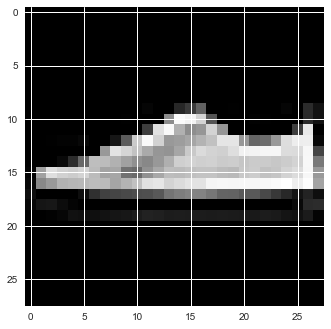

7


In [24]:
# visualizing as picture
def draw_image(sample):
    img = sample.reshape((28,28))
    plt.imshow(img,cmap='gray')
    plt.show()
draw_image(X_test[0])
print(y_test[0])

In [25]:
#normalizing data
X_train = (((X_train-X_train.min())*255)/(X_train.max()-X_train.min()))
X_test = (((X_test-X_test.min())*255)/(X_test.max()-X_test.min()))

In [26]:
# Vectorized implemetation
def hypothesis(X,theta): 
    return sigmoid(X@theta)

def sigmoid(z):
    return 1.0/(1.0+np.exp(-1.0*z))
    
def error(X_t, y_t, theta):
    h = hypothesis(X_t,theta)
    return (-0.5*np.sum((y_t)*np.log(h)+(1-y_t)*np.log(1-h),axis=0))/X_t.shape[0];

def gradient(X_t, y_t, theta):
    return (np.transpose(X_t)@(hypothesis(X_t,theta)-y_t))/X_t.shape[0]

def gradient_descent(X_t, y_t, alpha, max_itr=500, threshold =0.0001):
    grad = np.zeros((X_t.shape[1],1))
    theta = np.zeros((X_t.shape[1],1))
    err = []
    acc = []
    
    for x in range(max_itr):
        grad = gradient(X_t, y_t, theta)
        theta = theta - alpha * grad
        err.append(error(X_t, y_t, theta))
        acc.append(accuracy(X_t, y_t, theta))
        if len(err) > 1 and (abs(err[x]-err[x-1])) < threshold:
            break
    return (theta,err,acc)

def gradient_batch_descent(X_t, y_t, alpha=0.01,max_itr=150, threshold=0.0001, batch_size=5):
    grad = np.zeros((X_t.shape[1],1))
    theta = np.zeros((X_t.shape[1],1))
    err = []
    t_err = []
    t_acc = []
    acc = []
    m = X_t.shape[0]
    for x in range(max_itr):
        for i in range(int(m/batch_size)):
            err = []
            acc = []
            grad = gradient(X_t[i*batch_size:(i+1)*batch_size,:], y_t[i*batch_size:(i+1)*batch_size],theta)
            theta = theta - alpha*grad;
            acc.append(accuracy(X_t, y_t, theta))
            err.append(error(X_t[i*batch_size:(i+1)*batch_size,:], y_t[i*batch_size:(i+1)*batch_size],theta))
        t_err.append(np.mean(err))
        t_acc.append(np.mean(acc))
        if len(t_err) > 1 and abs(np.mean(t_err[:])-np.mean(t_err[:-1])) <threshold:
            break
    return (theta,t_err,t_acc)

def predict(X_t,theta):
    return hypothesis(X_t,theta) > 0.5

def accuracy(X_t,y_t,theta):
    return np.sum(predict(X_t,theta)==y_t,axis=0)/(y_t.shape[0])

# create all training sets based on labels
def create_all_train(X_train,y_train):
    list_all = [[],[],[],[],[],[],[],[],[],[]]
    for i in range(y_train.shape[0]):
        list_all[y_train[i]].append(X_train[i])
    return np.array(list_all)

def combine_two_train(x1,len1,x2,len2):
    x = x1[0]
    for i in range(1,len1):
        x = np.vstack((x,x1[i]))
    for i in range(0,len2):
        x = np.vstack((x,x2[i]))
    y = np.ones((len1,1))
    y = np.vstack((y,np.zeros((len2,1))))
    d = np.hstack((y,x))
    np.random.seed(0)
    np.random.shuffle(d)
    return d[:,1:], d[:,0]
    
def build_classifers(X_train,y_train,label):
    list_all = create_all_train(X_train,y_train)
    theta_classifier = []
    for i in label:
        for j in label:
            if j==i:
                continue
            x_t,y_t = combine_two_train(list_all[i],len(list_all[i]),list_all[j],len(list_all[j]))
            theta,err,acc = gradient_batch_descent(x_t,y_t.reshape((-1,1)))
            theta_classifier.append((theta,i,j))
    return np.array(theta_classifier)
    

def predict_test(theta_classifier,x):
        list_predict = []
        for i in range(theta_classifier.shape[0]):
            pred = predict(x,theta_classifier[i][0])
            if pred == 1:
                list_predict.append(theta_classifier[i][1])
            else:
                list_predict.append(theta_classifier[i][2])
        list_predict = np.array(list_predict)
        index = stats.mode(list_predict).mode[0]
        return index

In [27]:
theta_classifier = build_classifers(X_train[:4000,:],y_train[:4000],cls)

/Users/akroh/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/Users/akroh/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in multiply
  # Remove the CWD from sys.path while we load stuff.


In [28]:
p = predict_test(theta_classifier,X_test[3])
print(y_test[3])
print(p)

3
3


In [29]:
# checking accuracy
def accuracy_multi_classifier(theta_classifier,X_test,y_test):
    acc = 0
    for i in range(X_test.shape[0]):
        acc += (predict_test(theta_classifier,X_test[i])==y_test[i])
    return acc/X_test.shape[0]

accuracy = accuracy_multi_classifier(theta_classifier,X_test,y_test)
print(accuracy)
# for 100 examples
# 66.6875 -- leave rem
# 61.7 ish -- with rem
# for 1000 examples
# 78.675 -- leave rem **best**
# 75.075 -- leave rem -- without randomize
# 69.3 -- with rem 
# 66.6375 -- with rem -- without randomize
# for 4000 examples
# 80.7875 -- leave rem

0.807875


# SKLEARN IMPLEMENTATION

In [12]:
import time
from sklearn.multiclass import OneVsOneClassifier,OneVsRestClassifier
from sklearn.linear_model import LogisticRegression

In [30]:
ovo = OneVsOneClassifier(estimator=LogisticRegression(random_state=5))
start = time.time()
ovo.fit(X_train[:4000,:],y_train[:4000])
end = time.time()
print("time taken for ovo ",end-start)
print("Score ovo",ovo.score(X_test,y_test))

time taken for ovo  6.110020160675049
Score ovo 0.807125


## One vs Rest Model

In [14]:
ovr = OneVsRestClassifier(estimator=LogisticRegression(random_state=5))
start = time.time()
ovr.fit(X_train[:1000,:],y_train[:1000])
end = time.time()
print("time taken for ovr ",end-start)
print("Score ovr",ovo.score(X_test,y_test))

time taken for ovr  1.5276100635528564
Score ovr 0.79


# KNN IMPLEMENTATION

In [31]:
def euclidean_distance(x1,x2):
    return np.sqrt(sum((x1-x2)**2))

def KNN(X,y,query,k=5):
    dist = []
    m = X.shape[0]
    for i in range(m):
        dist.append([euclidean_distance(X[i],query),y[i]])
    
    sorted_dist = sorted(dist)
    dist_k = sorted_dist[:k]
    dist_k = np.array(dist_k)
    dist_k_tuple = np.unique(dist_k[:,1],return_counts=True)
    res = dist_k_tuple[0][dist_k_tuple[1].argmax()]
    return res
        
def accuracy_KNN(X_t,y_t,X_tst,y_tst):
    mt = X_tst.shape[0]
    y_pred = []
    for i in range(mt):
        y_pred.append(KNN(X_t,y_t,X_tst[i]))
    return sum(y_pred==y_tst)/mt

In [16]:
k = KNN(X_train[:100,:],y_train[:100],X_test[0])
print("predicted value %d"%k)
print("actual value %d"%y_test[0])
print("accuracy %f"%accuracy_KNN(X_train[:1000,:],y_train[:1000],X_test,y_test))
# classifiaton accuracy is 0.752750 same as sklearn

predicted value 7
actual value 7
accuracy 0.752750


## Sklearn Implementation of KNN

In [37]:
from sklearn.neighbors import KNeighborsClassifier 

In [40]:
knn = KNeighborsClassifier(n_neighbors=5, p=2, metric='minkowski')
knn.fit(X_train[:1000,:],y_train[:1000])
print("actual value %d"%y_test[0])
print("accuracy of sklearn KNN ",knn.score(X_test,y_test))
# classifiaton accuracy is 0.752750 same as my algo

actual value 7
accuracy of sklearn KNN  0.75275
